In [98]:
import pandas as pd
import numpy
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("..")
from utils import pad_collate
from dataloader_comma import CommaDataset
from dataloader_nuscenes import NUScenesDataset
from model import VTN
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import os
from utils import * 
import re
from pathlib import Path
import argparse
import yaml

In [99]:
def rmse_loss(input, target, mask, reduction="mean"):
        out = (input[~mask]-target[~mask])**2
        return out.mean().sqrt() if reduction == "mean" else out 

def mae_loss(input, target, mask, reduction="mean"):
        out = (input[~mask]-target[~mask])
        return out.mean().abs() if reduction == "mean" else out 

In [100]:
def argparse_namespace_constructor(loader, node):
    values = loader.construct_mapping(node)
    namespace = argparse.Namespace()
    namespace.__dict__.update(values)
    return namespace

# Register the custom constructor with PyYAML
yaml.add_constructor('tag:yaml.org,2002:python/object:argparse.Namespace', argparse_namespace_constructor)


In [101]:
elems = []
n_feats = []
p = '/data1/jessica/data/toyota/ckpts_final/'
for elem in os.listdir(p):
    l = p + elem + "/lightning_logs"
    if len(os.listdir(p + elem)) == 0: continue
    for version in os.listdir(l):
        k = f'{l}/{version}/checkpoints/'
        if 'checkpoints' not in os.listdir(f'{l}/{version}'): continue 
        for filename in os.listdir(k):
            if "yaml" in filename:
                with open(k + filename, "r") as file:
                    yaml_data = yaml.load(file, Loader=yaml.FullLoader)
                    data_dict = vars(yaml_data)
                if 'dataset_fraction' in data_dict.keys():
                    print(k + filename)
                    elems.append(k)
                    n_feats.append(data_dict['dataset_fraction'])

/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_distance_none_True_0.75/lightning_logs/version_0/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_0.5/lightning_logs/version_1/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_distance_none_True_0.5/lightning_logs/version_1/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_0.75/lightning_logs/version_1/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_distance_none_True_0.25/lightning_logs/version_2/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_1/lightning_logs/version_2/checkpoints/hparams.yaml


In [113]:
res = {}
for i, elem in enumerate(elems):
    task = []
    for filename in os.listdir(elem):
        if '.csv' in filename: 
            df = pd.read_csv(elem + filename)
            if "nuscenes" in filename:
                df = df[0:1400]
            df.columns = ['preds', 'targets']
            m = (df['targets'] == 0).astype(bool) | (df['targets'] > 70).astype(bool)  if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            
            loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            task.append(round(loss3.item(), 2))
            res[filename + str(n_feats[i])] = task

In [114]:
res, n_feats

({'comma_distance_none_True_270.csvhuman': [1.77]}, ['human'])

In [115]:
rows = []
for elem in res.keys():
    task = "dist" if "dist" in elem else ("angle" if 'angle' in elem else "multitask")
    dataset = "comma" if 'comma' in elem else "nuscenes"
    size = 100 if '100' in elem else (300 if '300' in elem else (24 if '24' in elem else 48 if '48' in elem else "none"))
    val = res[elem]
    if task == 'multitask' or size == "none" or dataset != "nuscenes": continue
    rows.append({'task': task, 'dataset': dataset, "MAE": val[0], "size":size})

In [116]:
elems = []
n_feats = []
p = '/data1/jessica/data/toyota/ckpts_final/'
for elem in os.listdir(p):
    l = p + elem + "/lightning_logs"
    if len(os.listdir(p + elem)) == 0: continue
    for version in os.listdir(l):
        k = f'{l}/{version}/checkpoints/'
        if 'checkpoints' not in os.listdir(f'{l}/{version}'): continue 
        for filename in os.listdir(k):
            if "yaml" in filename:
                with open(k + filename, "r") as file:
                    yaml_data = yaml.load(file, Loader=yaml.FullLoader)
                    data_dict = vars(yaml_data)
                if 'dataset_fraction' in data_dict.keys():
                    print(data_dict)
                if 'n_scenarios' in data_dict:
                    print(k + filename)
                    elems.append(k)
                    n_feats.append(data_dict['n_scenarios'])


{'backbone': 'none', 'bs': 1, 'checkpoint_path': '', 'concept_features': True, 'dataset': 'nuscenes', 'dataset_fraction': 0.75, 'dataset_path': '/data1/shared/jessica/data1/data/toyota', 'dev_run': False, 'gpu_num': 0, 'ground_truth': 'normal', 'intervention_prediction': None, 'max_epochs': 600, 'n_scenarios': 643, 'new_version': True, 'save_path': '', 'task': 'distance', 'test': None, 'train': True}
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_distance_none_True_0.75/lightning_logs/version_0/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_angle_none_True_ablation/lightning_logs/version_4/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_angle_none_True_ablation/lightning_logs/version_3/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscenes_angle_none_True_ablation/lightning_logs/version_6/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_nuscen

In [7]:
res = {}
for elem in elems:
    task = []
    for filename in os.listdir(elem):
        if '.csv' in filename: 
            df = pd.read_csv(elem + filename)
            if "nuscenes" in filename:
                df = df[0:1400]
            df.columns = ['preds', 'targets']
            m = (df['targets'] == 0).astype(bool) | (df['targets'] > 50).astype(bool)  if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            
            
            loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            task.append(round(loss3.item(), 2))
            res[filename] = task


In [8]:

rows = []
for elem in res.keys():
    task = "dist" if "dist" in elem else ("angle" if 'angle' in elem else "multitask")
    dataset = "comma" if 'comma' in elem else "nuscenes"
    size = 100 if '100' in elem else (300 if '300' in elem else (24 if '24' in elem else 48 if '48' in elem else "none"))
    val = res[elem]
    if task == 'multitask' or size == "none" or dataset != "nuscenes": continue
    rows.append({'task': task, 'dataset': dataset, "MAE": val[0], "size":size})

In [9]:
pd.DataFrame(rows).sort_values('size').sort_values('task')

,task,dataset,MAE,size
6,angle,nuscenes,1.49,24
7,angle,nuscenes,0.60,48
5,angle,nuscenes,0.52,100
4,angle,nuscenes,4.01,300
0,dist,nuscenes,1.85,24
1,dist,nuscenes,0.02,48
3,dist,nuscenes,0.51,100
2,dist,nuscenes,2.27,300


In [93]:
elems

['/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_1/lightning_logs/version_0/checkpoints/',
 '/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_1/lightning_logs/version_2/checkpoints/',
 '/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_1/lightning_logs/version_1/checkpoints/']

In [222]:
elems = []
n_feats = []
p = '/data1/jessica/data/toyota/ckpts_final/'
for elem in os.listdir(p):
    l = p + elem + "/lightning_logs"
    if len(os.listdir(p + elem)) == 0: continue
    for version in os.listdir(l):
        k = f'{l}/{version}/checkpoints/'
        if 'checkpoints' not in os.listdir(f'{l}/{version}'): continue 
        for filename in os.listdir(k):
            if "yaml" in filename:
                with open(k + filename, "r") as file:
                    yaml_data = yaml.load(file, Loader=yaml.FullLoader)
                    data_dict = vars(yaml_data)
                if 'scenario_type' in data_dict:
                    print(k + filename)
                    elems.append(k)
                    n_feats.append(data_dict['scenario_type'])

res = {}
for i, elem in enumerate(elems):
    task = []
    for filename in os.listdir(elem):
        if '.csv' in filename: 
            df = pd.read_csv(elem + filename)
            if "nuscenes" in filename:
                df = df[0:1400]
            df.columns = ['preds', 'targets']
            m = (df['targets'] == 0).astype(bool) | (df['targets'] > 70).astype(bool)  if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            
            
            loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            task.append(round(loss3.item(), 2))
            res[filename + n_feats[i]] = task

rows = []
for elem in res.keys():
    task = "dist" if "dist" in elem else ("angle" if 'angle' in elem else "multitask")
    dataset = "comma" if 'comma' in elem else "nuscenes"
    size = 100 if '100' in elem else (300 if '300' in elem else (24 if '24' in elem else 48 if '48' in elem else "none"))
    val = res[elem]
    if task == 'multitask' or size == "none" or dataset != "nuscenes": continue
    rows.append({'task': task, 'dataset': dataset, "MAE": val[0], "size":size})

/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_1/lightning_logs/version_3/checkpoints/hparams.yaml
/data1/jessica/data/toyota/ckpts_final/ckpts_final_comma_distance_none_True_1/lightning_logs/version_2/checkpoints/hparams.yaml


In [223]:
res, n_feats

({'comma_distance_none_True_270.csvgpt': [0.89],
  'comma_distance_none_True_270.csvhuman': [1.77]},
 ['gpt', 'human'])

In [107]:
p = '/data1/jessica/data/toyota/ckpts_final/'

experiments = os.listdir(p)
res = {}
res_abl = {}
res_ckpt = {}
for elem in experiments:
    if 'ablation' in elem or "0.75" in elem or '0.25' in elem or "1" in elem or '0.5' in elem: continue
    path = p + elem + "/lightning_logs/" 
    if len(os.listdir(p + elem)) == 0: continue
    vs = os.listdir(path)
    filt = []
    for elem1 in vs: 
        if 'version' in elem1:
            filt.append(elem1)
    versions =[int(elem.split("_")[-1])for elem in filt]
    versions = sorted(versions)
    if len(versions) == 0: continue
    version = f"version_{versions[-1]}"
    #print(versions, version)
    #if elem == 'ckpts_final_comma_distance_clip' or elem == 'ckpts_final_comma_multitask_vit': version = "version_0"
    

    checkpoint_path = path + version + "/checkpoints/"
    if "checkpoints" not in os.listdir(path + version): continue
    files = os.listdir(checkpoint_path)

    task = []
    ckpt = []
    task_abl = []
    files = sorted(files)

    if "hparams.yaml" in files: 
        with open(checkpoint_path + "/hparams.yaml" , "r") as file:   
            yaml_data = yaml.load(file, Loader=yaml.FullLoader)
            data_dict = vars(yaml_data)
            if 'dataset_fraction' in data_dict:
                if  data_dict['dataset_fraction'] != 1:
                    print(elem)
                    continue
            if 'n_scenarios' in data_dict:
                if  data_dict['n_scenarios'] != 643:
                    print(elem, data_dict['n_scenarios'])
                    continue
    for filename in files: 
        if filename.endswith(".csv"):
            df = pd.read_csv(checkpoint_path + filename)
            if "nuscenes" in filename:
                df = df[0:1400]
            df.columns = ['preds', 'targets']
            m = (df['targets'] == 0).astype(bool) | (df['targets'] > 70).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            
            loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            loss4 = rmse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            if "00" in filename:
                task_abl.append(round(loss3.item(), 2))
            else:
                task.append((round(loss3.item(), 2),round(loss4.item(), 2)))
        if filename.endswith(".ckpt"):
            ckpt.append(checkpoint_path + '/' + filename)
    res[elem] = task
    if len(task_abl) != 0:
        res_abl[elem] = task_abl
    res_ckpt[elem] = ckpt
rows = []
for elem in res.keys():
    splitted = elem.split("_")
    data = splitted[2]
    task = splitted[3]
    backbone = splitted[4]
    if len(splitted) > 5:
        concept = splitted[5]
    else: 
        concept = False
    rows.append({"Concept": concept, "Task": task, "Backbone": backbone, "Dataset": data, "t-RMSE": res[elem]})

#pd.DataFrame(rows).sort_values('size').sort_values('task')


In [108]:
rows

[{'Concept': False,
  'Task': 'distance',
  'Backbone': 'resnet',
  'Dataset': 'comma',
  't-RMSE': [(2.9, 6.4)]},
 {'Concept': False,
  'Task': 'multitask',
  'Backbone': 'none',
  'Dataset': 'comma',
  't-RMSE': [(0.36, 4.76), (0.94, 4.03)]},
 {'Concept': 'True',
  'Task': 'angle',
  'Backbone': 'resnet',
  'Dataset': 'comma',
  't-RMSE': [(0.38, 4.12)]},
 {'Concept': False,
  'Task': 'angle',
  'Backbone': 'vit',
  'Dataset': 'nuscenes',
  't-RMSE': [(4.77, 26.41)]},
 {'Concept': False,
  'Task': 'multitask',
  'Backbone': 'none',
  'Dataset': 'nuscenes',
  't-RMSE': [(0.42, 16.08), (6.65, 7.81)]},
 {'Concept': False,
  'Task': 'multitask',
  'Backbone': 'resnet',
  'Dataset': 'nuscenes',
  't-RMSE': [(9.51, 37.45), (43.81, 50.96)]},
 {'Concept': False,
  'Task': 'multitask',
  'Backbone': 'resnet',
  'Dataset': 'comma',
  't-RMSE': [(0.37, 2.93), (3.93, 6.07)]},
 {'Concept': False,
  'Task': 'angle',
  'Backbone': 'resnet',
  'Dataset': 'comma',
  't-RMSE': [(0.04, 3.32)]},
 {'Conc

In [109]:
# The list of dictionaries
df = pd.DataFrame(rows)

# Pivot the DataFrame
df_pivot = pd.pivot_table(df, values='t-RMSE', index=['Dataset', 'Backbone', 'Concept'], columns='Task', aggfunc=lambda x: x)

# Rename the columns
df_pivot.columns = [f'{col}-MAE' for col in df_pivot.columns]
# Reset the index
df_pivot = df_pivot.reset_index()
#df_pivot['Feat. Size'] = [512, 643, 512, 768, 512, 643, 512, 768]
#df_pivot = df_pivot[["Dataset", "Backbone", 'Feat. Size', 'angle-MAE', 'distance-MAE', 'multiangle-MAE', 'multidistance-MAE']].round(2)



In [110]:
df_pivot

,Dataset,Backbone,Concept,angle-MAE,distance-MAE,multitask-MAE
0,comma,clip,False,"[(0.04, 2.14)]","[(6.99, 8.87)]","[(0.22, 2.71), (8.09, 9.85)]"
1,comma,none,False,"[(0.71, 5.34)]","[(0.05, 4.19)]","[(0.36, 4.76), (0.94, 4.03)]"
2,comma,resnet,False,"[(0.04, 3.32)]","[(2.9, 6.4)]","[(0.37, 2.93), (3.93, 6.07)]"
3,comma,resnet,True,"[(0.38, 4.12)]","[(0.1, 4.62)]","[(2.13, 3.83), (1.36, 4.41)]"
4,comma,vit,False,"[(0.07, 3.04)]","[(3.77, 7.58)]","[(0.8, 2.99), (5.24, 6.87)]"
5,nuscenes,clip,False,"[(0.72, 13.8)]","[(5.46, 8.08)]","[(3.65, 17.59), (3.47, 6.71)]"
6,nuscenes,none,False,"[(2.8, 16.12)]","[(4.21, 7.41)]","[(0.42, 16.08), (6.65, 7.81)]"
7,nuscenes,resnet,False,"[(4.94, 29.25)]","[(26.5, 32.22)]","[(9.51, 37.45), (43.81, 50.96)]"
8,nuscenes,resnet,True,"[(2.51, 19.77)]","[(4.8, 9.02)]","[(2.42, 19.45), (4.26, 7.74)]"
9,nuscenes,vit,False,"[(4.77, 26.41)]","[(1.31, 4.71)]","[(0.7, 23.13), (16.62, 26.8)]"


In [83]:
df

,Concept,Task,Backbone,Dataset,t-RMSE
0,False,distance,resnet,comma,"[(0.36, 1.33)]"
1,False,multitask,none,comma,"[(0.65, 4.14), (1.4, 2.42)]"
2,True,angle,resnet,comma,"[(0.64, 3.47)]"
3,False,angle,vit,nuscenes,"[(8.27, 26.64)]"
4,False,multitask,none,nuscenes,"[(1.79, 15.27), (nan, nan)]"
5,False,multitask,resnet,nuscenes,"[(10.86, 36.45), (nan, nan)]"
6,False,multitask,resnet,comma,"[(0.4, 2.72), (0.04, 1.23)]"
7,False,angle,resnet,comma,"[(0.17, 3.0)]"
8,False,multitask,vit,nuscenes,"[(2.83, 23.4), (nan, nan)]"
9,True,multitask,resnet,comma,"[(2.29, 3.64), (1.12, 4.09)]"


In [18]:
df_pivot = df_pivot[["Dataset", "Backbone", 'angle-MAE', 'distance-MAE', 'multitask-MAE']].round(2)
df_pivot

,Dataset,Backbone,angle-MAE,distance-MAE,multitask-MAE
0,comma,clip,0.02,3.54,"[0.18, 4.11]"
1,comma,none,0.29,2.46,"[0.03, 1.87]"
2,comma,resnet,0.32,4.24,"[0.25, 3.85]"
3,comma,resnet,0.84,[],"[2.08, 1.84]"
4,comma,vit,0.01,0.85,"[1.05, 4.41]"
5,nuscenes,clip,1.8,5.46,"[3.55, 3.47]"
6,nuscenes,none,[],4.21,"[0.36, 6.65]"
7,nuscenes,resnet,5.87,26.5,"[9.42, 43.81]"
8,nuscenes,resnet,0.97,NaN,[]
9,nuscenes,vit,3.75,[],"[0.96, 16.62]"


In [19]:

p = '/home/jessica/personalized_driving_toyota/'

experiments = os.listdir(p)
res = {}
res_ckpt = {}
for filename in experiments: 
    if filename.endswith(".csv"):
        df = pd.read_csv(p + filename)
        df.columns = ['preds', 'targets']
        m = (df['targets'] == 0).astype(bool) | (df['targets'] > 40).astype(bool)  if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
        
        loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
        res[filename] = round(loss3.item(), 2)
rows = []
for elem in res.keys():
    splitted = elem.split("_")
    print(elem)
    task = "multi" if 'multi' in elem else ("angle" if 'angle' in elem else 'distance')
    if "multi" in task:
        task = task + ("angle" if "angle" in elem else "distance")
    backbone = "clip" if "clip" in elem else ("resnet" if "resnet" in elem else ("none" if 'none' in elem else "vit"))
    data = 'nuscenes' if 'nuscenes' in elem else "comma"
    rows.append({"Task": task, "Backbone": backbone, "Dataset": data, "t-RMSE": round(res[elem], 2)})

angle_multi_nuscenes_multitask_none_True.csv
dist_multi_nuscenes_multitask_clip_None.csv
nuscenes_angle_vit_None.csv
nuscenes_angle_clip_None.csv
angle_multi_nuscenes_multitask_resnet_None.csv
angle_multi_nuscenes_multitask_clip_None.csv
dist_multi_nuscenes_multitask_vit_None.csv
angle_multi_nuscenes_multitask_resnet_True.csv
dist_multi_nuscenes_multitask_resnet_True.csv
nuscenes_angle_resnet_None.csv
dist_multi_nuscenes_multitask_none_True.csv
dist_multi_nuscenes_multitask_resnet_None.csv
angle_multi_nuscenes_multitask_vit_None.csv
nuscenes_distance_clip_None.csv
nuscenes_distance_none_True.csv
nuscenes_distance_resnet_None.csv


In [20]:
# The list of dictionaries
df = pd.DataFrame(rows)
data = rows

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame
df_pivot = pd.pivot_table(df, values='t-RMSE', index=['Dataset', 'Backbone'], columns='Task', aggfunc=lambda x: x)

# Rename the columns
df_pivot.columns = [f'{col}-MAE' for col in df_pivot.columns]
# Reset the index
df_pivot = df_pivot.reset_index()
#df_pivot['Feat. Size'] = [512, 643, 512, 768, 512, 643, 512, 768]
#df_pivot = df_pivot[["Dataset", "Backbone", 'Feat. Size', 'angle-MAE', 'distance-MAE', 'multiangle-MAE', 'multidistance-MAE']].round(2)



In [21]:

df_pivot = df_pivot[["Dataset", "Backbone", 'angle-MAE', 'distance-MAE', 'multiangle-MAE', 'multidistance-MAE']].round(2)
df_pivot

,Dataset,Backbone,angle-MAE,distance-MAE,multiangle-MAE,multidistance-MAE
0,nuscenes,clip,1.18,5.57,5.01,4.17
1,nuscenes,none,NaN,5.07,4.98,6.62
2,nuscenes,resnet,0.87,25.81,"[2.88, 3.03]","[7.88, 45.1]"
3,nuscenes,vit,10.1,NaN,7.27,29.45


In [23]:

p = '/data1/jessica/data/toyota/ckpts_final/'

experiments = os.listdir(p)
res = {}
res_abl = {}
res_ckpt = {}
for elem in experiments:
    path = p + elem + "/lightning_logs/" 
    if len(os.listdir(p + elem)) == 0: continue
    vs = os.listdir(path)
    filt = []
    for elem1 in vs: 
        if 'version' in elem1:
            filt.append(elem1)
    versions =[int(elem.split("_")[-1])for elem in filt]
    versions = sorted(versions)
    if len(versions) == 0: continue
    version = f"version_{versions[-1]}"
    #if elem == 'ckpts_final_comma_distance_clip' or elem == 'ckpts_final_comma_multitask_vit': version = "version_0"
    

    checkpoint_path = path + version + "/checkpoints/"
    if "checkpoints" not in os.listdir(path + version): continue
    files = os.listdir(checkpoint_path)

    task = []
    ckpt = []
    task_abl = []
    files = sorted(files)
    if sum([".csv" in filename for filename in files]) == 0: continue
    print(files)
    for filename in files: 
        if filename.endswith(".ckpt"):
            ckpt.append(checkpoint_path + '/' + filename)
    res_ckpt[elem] = ckpt

rows = []

for elem in res_ckpt.keys():
    minint = 1000000000
    for ckpt in res_ckpt[elem]:
        ckpt_num = int(ckpt.split('epoch=')[1].split("-step=")[0])
        if minint > ckpt_num: 
            minint = ckpt_num
        

    splitted = elem.split("_")
    data = splitted[2]
    task = splitted[3]
    backbone = splitted[4]
    if len(splitted) > 5:
        concept = splitted[5]
    else: 
        concept = backbone == "none"
    rows.append({"Concept": concept, "Task": task, "Backbone": backbone, "Dataset": data, "ckpt": minint})




['distance.csv', 'epoch=16-step=2108.ckpt', 'epoch=30-step=3844.ckpt', 'hparams.yaml']
['angle_multi.csv', 'dist_multi.csv', 'epoch=66-step=4154.ckpt', 'epoch=72-step=4526.ckpt', 'hparams.yaml']
['angle.csv', 'epoch=36-step=9139.ckpt', 'epoch=37-step=9386.ckpt', 'hparams.yaml']
['angle.csv', 'epoch=304-step=23765.ckpt', 'epoch=351-step=24893.ckpt', 'hparams.yaml']
['epoch=571-step=59488.ckpt', 'epoch=582-step=60632.ckpt', 'hparams.yaml', 'nuscenes_distance_none_True_643.csv']
['comma_distance_none_True_24.csv', 'epoch=136-step=33839.ckpt', 'epoch=149-step=37050.ckpt', 'hparams.yaml']
['angle_multi.csv', 'dist_multi.csv', 'epoch=581-step=8718.ckpt', 'epoch=585-step=8830.ckpt', 'hparams.yaml']
['angle_multi.csv', 'dist_multi.csv', 'epoch=529-step=7224.ckpt', 'epoch=535-step=7332.ckpt', 'hparams.yaml']
['angle_multi_nuscenes_multitask_none_True.csv', 'dist_multi_nuscenes_multitask_none_True.csv', 'epoch=595-step=82844.ckpt', 'epoch=598-step=83261.ckpt', 'hparams.yaml']
['angle_multi.csv',

In [11]:
pd.DataFrame(rows).groupby(by='Backbone')

In [12]:
df = pd.DataFrame(rows)

In [13]:
df['n'] = df["Concept"].astype(str) + df["Backbone"]

In [14]:
df.groupby(by='n').mean()

/tmp/ipykernel_2822117/1395744031.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by='n').mean()


,ckpt
n,
Falseclip,273.000000
Falseresnet,265.500000
Falsevit,159.166667
Truenone,283.187500
Trueresnet,167.000000


In [17]:
srt = df.sort_values("Task").sort_values("Dataset")

In [25]:
srt[srt['Dataset'] == 'comma'].groupby(by='n').std()

/tmp/ipykernel_2822117/3504325409.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  srt[srt['Dataset'] == 'comma'].groupby(by='n').std()


,ckpt
n,
Falseclip,37.541089
Falseresnet,25.514702
Falsevit,90.266273
Truenone,65.721273
Trueresnet,77.848143


In [22]:
srt[srt['Dataset'] == 'comma'].groupby(by='n').mean()

/tmp/ipykernel_2822117/2560272186.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  srt[srt['Dataset'] == 'comma'].groupby(by='n').mean()


,ckpt
n,
Falseclip,102.666667
Falseresnet,35.000000
Falsevit,61.000000
Truenone,75.428571
Trueresnet,75.333333


In [24]:
srt[srt['Dataset'] == 'nuscenes'].groupby(by='n').mean()


/tmp/ipykernel_2822117/900716118.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  srt[srt['Dataset'] == 'nuscenes'].groupby(by='n').mean()


,ckpt
n,
Falseclip,443.333333
Falseresnet,496.000000
Falsevit,257.333333
Truenone,444.777778
Trueresnet,258.666667


In [ ]:
#regression analysis versus distances


In [216]:
p = '/data1/jessica/data/toyota/ckpts_final/'

experiments = os.listdir(p)
res = {}
res_abl = {}
res_ckpt = {}
for elem in experiments:
    if 'ablation' in elem or "0.75" in elem or '0.25' in elem or "1" in elem or '0.5' in elem: continue
    path = p + elem + "/lightning_logs/" 
    if len(os.listdir(p + elem)) == 0: continue
    vs = os.listdir(path)
    filt = []
    for elem1 in vs: 
        if 'version' in elem1:
            filt.append(elem1)
    versions =[int(elem.split("_")[-1])for elem in filt]
    versions = sorted(versions)
    if len(versions) == 0: continue
    version = f"version_{versions[-1]}"
    #print(versions, version)
    #if elem == 'ckpts_final_comma_distance_clip' or elem == 'ckpts_final_comma_multitask_vit': version = "version_0"
    

    checkpoint_path = path + version + "/checkpoints/"
    if "checkpoints" not in os.listdir(path + version): continue
    files = os.listdir(checkpoint_path)

    task = []
    ckpt = []
    task_abl = []
    files = sorted(files)

    if "hparams.yaml" in files: 
        with open(checkpoint_path + "/hparams.yaml" , "r") as file:   
            yaml_data = yaml.load(file, Loader=yaml.FullLoader)
            data_dict = vars(yaml_data)
            if 'dataset_fraction' in data_dict:
                if  data_dict['dataset_fraction'] != 1:
                    print(elem)
                    continue
            if 'n_scenarios' in data_dict:
                if  data_dict['n_scenarios'] != 643:
                    print(elem, data_dict['n_scenarios'])
                    continue
    for filename in files: 
        if filename.endswith(".csv"):
            df = pd.read_csv(checkpoint_path + filename)
            if "nuscenes" in filename:
                df = df#[0:1400]
            df.columns = ['preds', 'targets']
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 20).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            
            loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 40).astype(bool) | (df['targets'].abs() <= 20).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            loss4 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 60).astype(bool) | (df['targets'].abs() <= 40).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            loss5 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() < 60).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            loss7 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            if "00" in filename:
                task_abl.append(round(loss3.item(), 2))
            else:
                task.append((round(loss3.item(), 2),round(loss4.item(), 2),round(loss5.item(), 2),round(loss7.item(), 2)))
        if filename.endswith(".ckpt"):
            ckpt.append(checkpoint_path + '/' + filename)
    res[elem] = task
    if len(task_abl) != 0:
        res_abl[elem] = task_abl
    res_ckpt[elem] = ckpt
rows = []
for elem in res.keys():
    splitted = elem.split("_")
    data = splitted[2]
    task = splitted[3]
    backbone = splitted[4]
    if len(splitted) > 5:
        concept = splitted[5]
    else: 
        concept = False
    rows.append({"Concept": concept, "Task": task, "Backbone": backbone, "Dataset": data, "t-RMSE": res[elem]})

#pd.DataFrame(rows).sort_values('size').sort_values('task')


In [217]:
# The list of dictionaries
df = pd.DataFrame(rows)

# Pivot the DataFrame
df_pivot = pd.pivot_table(df, values='t-RMSE', index=['Dataset', 'Backbone', 'Concept'], columns='Task', aggfunc=lambda x: x)

# Rename the columns
df_pivot.columns = [f'{col}-MAE' for col in df_pivot.columns]
# Reset the index
df_pivot = df_pivot.reset_index()
#df_pivot['Feat. Size'] = [512, 643, 512, 768, 512, 643, 512, 768]
#df_pivot = df_pivot[["Dataset", "Backbone", 'Feat. Size', 'angle-MAE', 'distance-MAE', 'multiangle-MAE', 'multidistance-MAE']].round(2)



In [218]:
df_pivot

,Dataset,Backbone,Concept,angle-MAE,distance-MAE,multitask-MAE
0,comma,clip,False,"[(0.0, 2.06, 5.4, 53.27)]","[(0.52, 4.55, 10.24, 18.09)]","[(0.18, 2.82, 14.45, 66.21), (0.79, 4.99, 11.9..."
1,comma,none,False,"[(0.7, 10.9, 33.59, 95.18)]","[(1.29, 2.5, 0.43, 11.02)]","[(0.37, 11.48, 34.26, 83.11), (1.44, 1.7, 2.2,..."
2,comma,resnet,False,"[(0.02, 6.12, 25.01, 80.24)]","[(1.85, 4.32, 2.07, 11.92)]","[(0.33, 2.09, 17.83, 70.51), (1.32, 4.98, 4.25..."
3,comma,resnet,True,"[(0.4, 11.28, 34.65, 77.51)]","[(3.4, 3.04, 2.2, 10.35)]","[(2.12, 3.15, 21.55, 62.67), (2.59, 1.51, 0.69..."
4,comma,vit,False,"[(0.05, 6.13, 22.8, 75.8)]","[(5.01, 0.6, 8.15, 19.55)]","[(0.74, 1.45, 7.15, 64.47), (1.43, 3.76, 6.71,..."
5,nuscenes,clip,False,"[(1.1, 1.33, 2.13, 6.43)]","[(14.98, 5.27, 4.06, 7.01)]","[(5.12, 2.71, 4.74, 8.38), (16.61, 3.33, 1.06,..."
6,nuscenes,none,False,"[(0.27, 0.14, 5.29, 4.67)]","[(16.18, 5.42, 3.02, 4.83)]","[(2.13, 0.93, 0.04, 13.88), (15.86, 6.87, 3.73..."
7,nuscenes,resnet,False,"[(6.68, 9.78, 6.15, 3.91)]","[(45.38, 25.09, 27.59, 10.14)]","[(6.93, 0.98, 42.25, 25.18), (61.09, 41.74, 47..."
8,nuscenes,resnet,True,"[(1.54, 3.16, 0.65, 23.05)]","[(18.35, 6.63, 5.16, 14.09)]","[(0.04, 0.07, 0.59, 12.47), (16.46, 5.12, 1.72..."
9,nuscenes,vit,False,"[(0.58, 0.81, 24.71, 31.48)]","[(11.47, 2.31, 4.74, 18.2)]","[(4.1, 4.05, 5.63, 26.79), (34.79, 19.69, 0.96..."


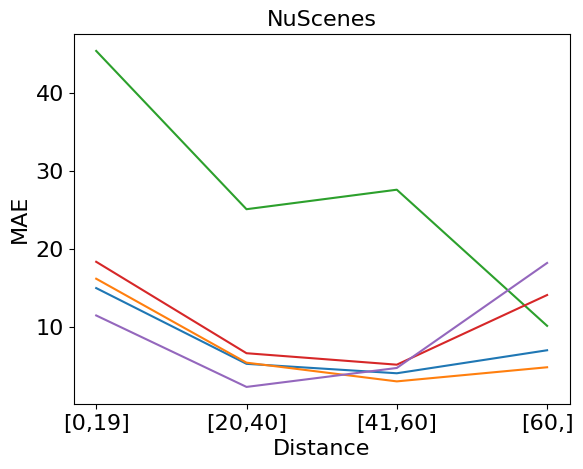

In [219]:
categories = ["[0,19]", "[20,40]", "[41,60]", "[60,]"]
df_pivot_comma = df_pivot[df_pivot['Dataset'] =='nuscenes']
for i in range(df_pivot_comma['distance-MAE'].shape[0]):
    angle = list(pd.Series(df_pivot_comma['distance-MAE'].iloc[i][0]).interpolate(method='linear'))
    x_positions = np.arange(len(categories))
    plt.plot(x_positions, list(angle))

# Relabel the x-axis tick positions with the original categorical values

plt.xticks(x_positions, categories)
#plt.legend(['CLIP', "Concept", "ResNet", "ResNet+Concept", "ViT"])
plt.xlabel('Distance', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.xticks(fontsize=16)
plt.title("NuScenes", fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("dist_nuscenes.pdf")

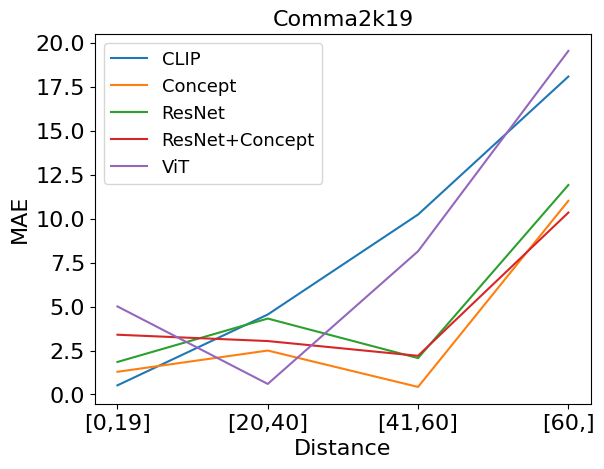

In [210]:
df_pivot_comma = df_pivot[df_pivot['Dataset'] =='comma']
categories = ["[0,19]", "[20,40]", "[41,60]", "[60,]"]
for i in range(df_pivot_comma['distance-MAE'].shape[0]):
    angle = list(pd.Series(df_pivot_comma['distance-MAE'].iloc[i][0]).interpolate(method='linear'))
    x_positions = np.arange(len(categories))
    plt.plot(x_positions, list(angle))

# Relabel the x-axis tick positions with the original categorical values
plt.xticks(x_positions, categories)
plt.title("Comma2k19",fontsize=16)
plt.legend(['CLIP', "Concept", "ResNet", "ResNet+Concept", "ViT"], fontsize=13)
plt.xlabel('Distance', fontsize=16)

plt.ylabel('MAE', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("dist_comma.pdf")


In [211]:
p = '/data1/jessica/data/toyota/ckpts_final/'

experiments = os.listdir(p)
res = {}
res_abl = {}
res_ckpt = {}
for elem in experiments:
    if 'ablation' in elem or "0.75" in elem or '0.25' in elem or "1" in elem or '0.5' in elem: continue
    path = p + elem + "/lightning_logs/" 
    if len(os.listdir(p + elem)) == 0: continue
    vs = os.listdir(path)
    filt = []
    for elem1 in vs: 
        if 'version' in elem1:
            filt.append(elem1)
    versions =[int(elem.split("_")[-1])for elem in filt]
    versions = sorted(versions)
    if len(versions) == 0: continue
    version = f"version_{versions[-1]}"
    #print(versions, version)
    #if elem == 'ckpts_final_comma_distance_clip' or elem == 'ckpts_final_comma_multitask_vit': version = "version_0"
    

    checkpoint_path = path + version + "/checkpoints/"
    if "checkpoints" not in os.listdir(path + version): continue
    files = os.listdir(checkpoint_path)

    task = []
    ckpt = []
    task_abl = []
    files = sorted(files)

    if "hparams.yaml" in files: 
        with open(checkpoint_path + "/hparams.yaml" , "r") as file:   
            yaml_data = yaml.load(file, Loader=yaml.FullLoader)
            data_dict = vars(yaml_data)
            if 'dataset_fraction' in data_dict:
                if  data_dict['dataset_fraction'] != 1:
                    print(elem)
                    continue
            if 'n_scenarios' in data_dict:
                if  data_dict['n_scenarios'] != 643:
                    print(elem, data_dict['n_scenarios'])
                    continue
    for filename in files: 
        if filename.endswith(".csv"):
            df = pd.read_csv(checkpoint_path + filename)
            if "nuscenes" in filename:
                df = df#[0:1400]
            df.columns = ['preds', 'targets']
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 10).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            
            loss3 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 20).astype(bool) | (df['targets'].abs() <= 10).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            loss4 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 30).astype(bool) | (df['targets'].abs() <= 20).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            loss5 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            m = (df['targets'] == 0).astype(bool) | (df['targets'].abs() > 40).astype(bool) | (df['targets'].abs() <= 30).astype(bool)  #if "angle" not in elem  else (df['targets'] == np.inf).astype(bool)
            loss6 = mae_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m))
            if "00" in filename:
                task_abl.append(round(loss3.item(), 2))
            else:
                task.append((round(loss3.item(), 2),round(loss4.item(), 2),round(loss5.item(), 2),round(loss5.item(), 2)))
        if filename.endswith(".ckpt"):
            ckpt.append(checkpoint_path + '/' + filename)
    res[elem] = task
    if len(task_abl) != 0:
        res_abl[elem] = task_abl
    res_ckpt[elem] = ckpt
rows = []
for elem in res.keys():
    splitted = elem.split("_")
    data = splitted[2]
    task = splitted[3]
    backbone = splitted[4]
    if len(splitted) > 5:
        concept = splitted[5]
    else: 
        concept = False
    rows.append({"Concept": concept, "Task": task, "Backbone": backbone, "Dataset": data, "t-RMSE": res[elem]})

#pd.DataFrame(rows).sort_values('size').sort_values('task')


In [212]:
# The list of dictionaries
df = pd.DataFrame(rows)

# Pivot the DataFrame
df_pivot = pd.pivot_table(df, values='t-RMSE', index=['Dataset', 'Backbone', 'Concept'], columns='Task', aggfunc=lambda x: x)

# Rename the columns
df_pivot.columns = [f'{col}-MAE' for col in df_pivot.columns]
# Reset the index
df_pivot = df_pivot.reset_index()
#df_pivot['Feat. Size'] = [512, 643, 512, 768, 512, 643, 512, 768]
#df_pivot = df_pivot[["Dataset", "Backbone", 'Feat. Size', 'angle-MAE', 'distance-MAE', 'multiangle-MAE', 'multidistance-MAE']].round(2)


In [213]:
df_pivot

,Dataset,Backbone,Concept,angle-MAE,distance-MAE,multitask-MAE
0,comma,clip,False,"[(0.01, 0.78, 3.12, 3.12)]","[(0.58, 1.25, 3.53, 3.53)]","[(0.16, 0.96, 3.49, 3.49), (0.54, 1.68, 3.93, ..."
1,comma,none,False,"[(0.79, 2.78, 11.12, 11.12)]","[(1.36, 1.24, 2.18, 2.18)]","[(0.45, 2.84, 11.2, 11.2), (1.4, 1.46, 1.96, 1..."
2,comma,resnet,False,"[(0.05, 1.19, 6.32, 6.32)]","[(0.36, 2.84, 4.2, 4.2)]","[(0.3, 1.71, 2.46, 2.46), (0.04, 2.17, 4.39, 4..."
3,comma,resnet,True,"[(0.49, 3.32, 10.24, 10.24)]","[(1.56, 4.62, 3.68, 3.68)]","[(2.13, 1.43, 3.24, 3.24), (1.12, 3.57, 1.96, ..."
4,comma,vit,False,"[(0.06, 0.74, 6.29, 6.29)]","[(4.16, 5.58, 1.11, 1.11)]","[(0.76, 0.06, 0.13, 0.13), (0.13, 2.29, 3.37, ..."
5,nuscenes,clip,False,"[(1.2, 0.67, 1.57, 1.57)]","[(nan, 14.98, 5.86, 5.86)]","[(5.02, 5.48, 5.35, 5.35), (nan, 16.61, 4.46, ..."
6,nuscenes,none,False,"[(0.23, 0.45, 3.44, 3.44)]","[(nan, 16.18, 7.74, 7.74)]","[(2.3, 1.47, 3.35, 3.35), (nan, 15.86, 7.98, 7..."
7,nuscenes,resnet,False,"[(5.12, 12.86, 12.66, 12.66)]","[(nan, 45.38, 22.92, 22.92)]","[(6.54, 8.48, 8.85, 8.85), (nan, 61.09, 40.49,..."
8,nuscenes,resnet,True,"[(1.69, 0.97, 0.5, 0.5)]","[(nan, 18.35, 9.86, 9.86)]","[(0.13, 0.7, 4.12, 4.12), (nan, 16.46, 7.61, 7..."
9,nuscenes,vit,False,"[(0.47, 0.99, 2.12, 2.12)]","[(nan, 11.47, 3.58, 3.58)]","[(4.97, 0.64, 1.64, 1.64), (nan, 34.79, 16.68,..."


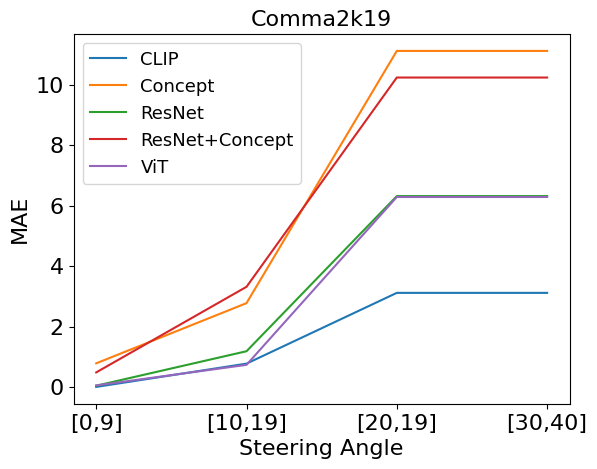

In [214]:
df_pivot_comma = df_pivot[df_pivot['Dataset'] =='comma']
categories = ["[0,9]", "[10,19]", "[20,19]", "[30,40]"]
for i in range(df_pivot_comma['angle-MAE'].shape[0]):
    angle = list(pd.Series(df_pivot_comma['angle-MAE'].iloc[i][0]).interpolate(method='linear'))
    x_positions = np.arange(len(categories))
    plt.plot(x_positions, list(angle))

# Relabel the x-axis tick positions with the original categorical values
plt.xticks(x_positions, categories)
plt.legend(['CLIP', "Concept", "ResNet", "ResNet+Concept", "ViT"],fontsize=13)
plt.xlabel('Steering Angle', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.title("Comma2k19",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("angle_comma.pdf")

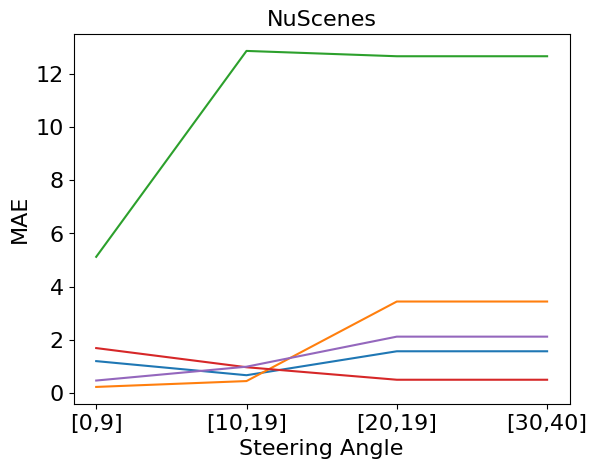

In [215]:
df_pivot_comma = df_pivot[df_pivot['Dataset'] =='nuscenes']
categories = ["[0,9]", "[10,19]", "[20,19]", "[30,40]"]
for i in range(df_pivot_comma['angle-MAE'].shape[0]):
    angle = list(pd.Series(df_pivot_comma['angle-MAE'].iloc[i][0]).interpolate(method='linear'))
    x_positions = np.arange(len(categories))
    plt.plot(x_positions, list(angle))

# Relabel the x-axis tick positions with the original categorical values
plt.xticks(x_positions, categories)
#plt.legend(['CLIP', "Concept", "ResNet", "ResNet+Concept", "ViT"],fontsize=14)
plt.xlabel('Steering Angle', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("NuScenes",fontsize=16)
plt.savefig("angle_nuscenes.pdf")
